In [2]:
!gpustat

blade.seas.upenn.edu  Thu Dec 16 07:18:14 2021  455.45.01
[0] RTX A6000        | 83'C, 100 % | 44138 / 48685 MB | sifanw(44135M)
[1] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[2] RTX A6000        | 31'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 33'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 83'C, 100 % | 44142 / 48685 MB | sifanw(44139M)


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from tqdm import tqdm, trange
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import os
from IPython.display import clear_output
import math
import matplotlib.pyplot as plt
import PIL
import timeit

import warnings
warnings.filterwarnings("ignore")

In [5]:
draw_box = lambda x1, y1, x2, y2: np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1], [x1, y1]])

# Load Data 

In [6]:
from data_loader import *
DATA_DIR = "../processdata/"
test_files = list(np.load("test_filenames.npy"))
train_files = list(np.load("train_filenames.npy"))
batch_size = 1
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Grayscale(),
                                                torchvision.transforms.Normalize([0.5], [0.5])])
train_loader = data_loader(train_files, DATA_DIR, batch_size = batch_size,transforms = transforms)
test_loader = data_loader(test_files, DATA_DIR, batch_size = batch_size,transforms = transforms)

## Visual Inspection

In [7]:
# data = next(iter(train_loader))
for data in train_loader:
    break
images, masks, bboxes, batch = data

# Model

In [43]:
# loading existing configuration
from architecture import *
# from config import *
checkpoint_path = f'../check_points/21_12_15_3'
hyper_parameters = np.load(f'{checkpoint_path}/hyper_parameters.npy', allow_pickle = True).item()
print(hyper_parameters)
num_epoch = 75
eps = hyper_parameters['eps']
                       
num_grids = hyper_parameters['num_grids']
scale_ranges = hyper_parameters['scale_ranges']
postprocess_cfg = dict()

{'num_grids': [90, 60, 30, 10], 'scale_ranges': ((0.05, 0.4), (0.1, 0.5), (0.4, 0.7), (0.6, 1)), 'eps': 0.2, 'optimizer': 'Adam', 'mask_weight': 1.0, 'cate_weight': 1.0}


In [44]:
print(hyper_parameters)

{'num_grids': [90, 60, 30, 10], 'scale_ranges': ((0.05, 0.4), (0.1, 0.5), (0.4, 0.7), (0.6, 1)), 'eps': 0.2, 'optimizer': 'Adam', 'mask_weight': 1.0, 'cate_weight': 1.0}


## SOLO

In [45]:
class SOLO(SOLO_head):    
    def __init__(self,
                 scale_ranges=scale_ranges,
                 num_grids=num_grids, 
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                    alpha=0.25,
                                    weight=1),
                 postprocess_cfg=postprocess_cfg):  
        super(SOLO, self).__init__(scale_ranges, num_grids, mask_loss_cfg, cate_loss_cfg, postprocess_cfg)
    
    
        self.backbone = FPN(Bottleneck, [3,4,6,3])
    
    def forward(self, images, device, eval=False, original_img = None):
            
        feature_pyramid = list(self.backbone(images)) 

        category_predictions = []
        mask_predictions = []

        if eval == True:
            
            for i, v in enumerate(feature_pyramid):
                num_grid = self.num_grids[i]
                category_pred = nn.functional.interpolate(v, size=[num_grid, num_grid], mode="bilinear", align_corners = True)
                category_pred = self.cate_branch(category_pred)
                category_predictions.append(self.points_nms(category_pred).permute(0,2,3,1))

                meshxy = torch.stack(torch.meshgrid(torch.linspace(-1,1,v.shape[-2]), torch.linspace(-1,1,v.shape[-1])))
                batch_meshxy = torch.tile(meshxy, (images.shape[0],1,1,1)).to(device)
                new_v = torch.cat((v, batch_meshxy), 1)

                mask_pred = self.ins_outs[i](self.ins_branch(new_v))

                mask_predictions.append(nn.functional.interpolate(mask_pred, size=original_img, mode='bilinear', align_corners = True))
            return category_predictions, mask_predictions         
            
        else:
            for i, v in enumerate(feature_pyramid):
                num_grid = self.num_grids[i]
                category_pred = nn.functional.interpolate(v, size=[num_grid, num_grid], mode="bilinear", align_corners = True)
                category_predictions.append(self.cate_branch(category_pred))

                meshxy = torch.stack(torch.meshgrid(torch.linspace(-1,1,v.shape[-2]), torch.linspace(-1,1,v.shape[-1])))
                batch_meshxy = torch.tile(meshxy, (images.shape[0],1,1,1)).to(device)
                new_v = torch.cat((v, batch_meshxy), 1)

                mask_pred = self.ins_outs[i](self.ins_branch(new_v))

                mask_predictions.append(nn.functional.interpolate(mask_pred, scale_factor=2, mode='bilinear', align_corners = True))
            return category_predictions, mask_predictions 

In [46]:
# device = 'cuda:0'
device = 'cuda:0'
model = SOLO().to(device)
backbone_out = model.backbone(torch.zeros(0,1,313,313).to(device))
model.featmap_sizes = [list(f.shape[-2:]) for f in backbone_out]
labels = [torch.ones(b.shape[0]) for b in bboxes]
masks, bboxes = [torch.Tensor(m) for m in masks], [torch.Tensor(b) for b in bboxes]
target = model.generate_single_target(bboxes[0], labels[0], masks[0], model.featmap_sizes, eps = eps)

((0.05, 0.4), (0.1, 0.5), (0.4, 0.7), (0.6, 1))
[90, 60, 30, 10]


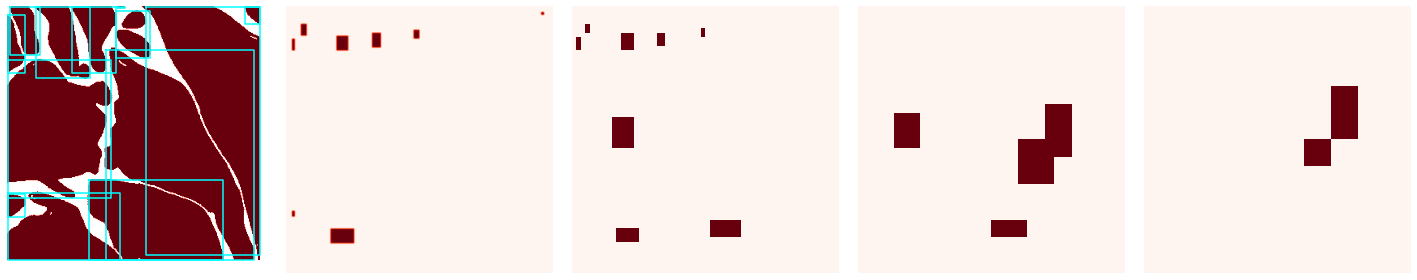

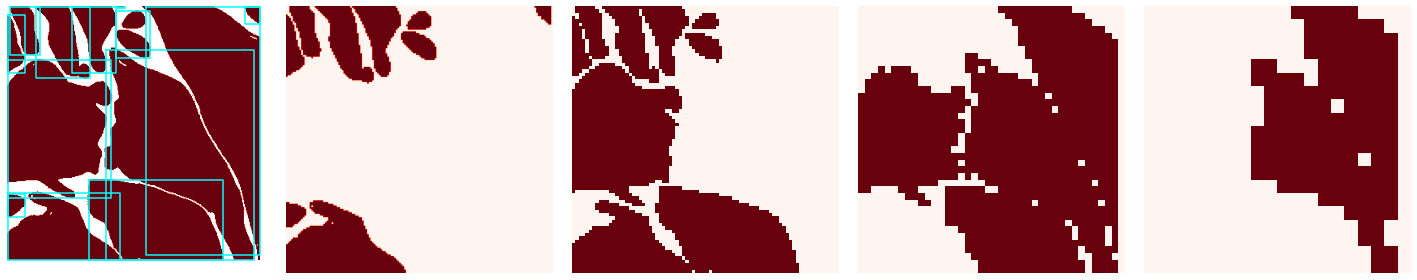

In [47]:
for data in train_loader:
    break
images, masks, bboxes, batch = data
labels = [torch.ones(b.shape[0]) for b in bboxes]
masks, bboxes = [torch.Tensor(m) for m in masks], [torch.Tensor(b) for b in bboxes]
target = model.generate_single_target(bboxes[0], labels[0], masks[0], model.featmap_sizes, eps = eps)

plt.figure(figsize=(20, 4)) 

plt.subplot(1,5,1)
for i, (msk, box) in enumerate(zip(masks[0], bboxes[0])):

    plt.imshow(msk, cmap = 'Reds', alpha = msk * 1.)
    plt.plot(*draw_box(*box * 313).T, color = 'aqua')
plt.axis('off')

for i in range(4):
    

    plt.subplot(1,5,i + 2)
    plt.imshow(target[1][i].reshape(num_grids[i],num_grids[i]), cmap = 'Reds')
    plt.axis('off')


plt.tight_layout()
plt.savefig('pixel_activation.pdf', dpi = 100)
plt.show()
plt.close()

plt.figure(figsize=(20, 4)) 

plt.subplot(1,5,1)
for i, (msk, box) in enumerate(zip(masks[0], bboxes[0])):

    plt.imshow(msk, cmap = 'Reds', alpha = msk * 1.)
    plt.plot(*draw_box(*box * 313).T, color = 'aqua')
plt.axis('off')

for i in range(4):
    

    plt.subplot(1,5,i + 2)
    plt.imshow(target[0][i].sum(0).reshape(*[ f * 2 for f in model.featmap_sizes[i]]) > 0, cmap = 'Reds')
    plt.axis('off')

plt.tight_layout()
plt.savefig('mask_assignment.pdf', dpi = 100)
plt.show()
plt.close()

# Loss plot

In [48]:
model.load_state_dict(torch.load(f'{checkpoint_path}/solo-epoch-{num_epoch}.pth')['model_state_dict'])

<All keys matched successfully>

In [49]:
loss_train_stor = np.load(f'{checkpoint_path}/loss-train-epoch-{num_epoch}.npy')
loss_val_stor = np.load(f'{checkpoint_path}/loss-val-epoch-{num_epoch}.npy')

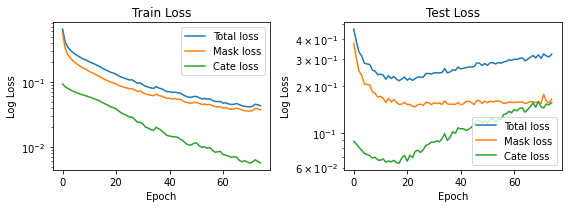

In [50]:
train_loss_avg = np.array(loss_train_stor).reshape(num_epoch,-1,3).mean(1)
test_loss_avg = np.array(loss_val_stor).reshape(num_epoch,-1,3).mean(1)

plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(0, num_epoch, train_loss_avg.shape[0], endpoint = False), train_loss_avg[:,2], label = 'Total loss')
plt.plot(np.linspace(0, num_epoch, train_loss_avg.shape[0], endpoint = False), train_loss_avg[:,1], label = 'Mask loss')
plt.plot(np.linspace(0, num_epoch, train_loss_avg.shape[0], endpoint = False), train_loss_avg[:,0], label = 'Cate loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Train Loss')
plt.legend()
plt.tight_layout()
# plt.savefig(f'{checkpoint_path}/loss_plot.pdf', dpi = 100)
plt.subplot(1,2,2)
plt.plot(np.linspace(0, num_epoch, test_loss_avg.shape[0], endpoint = False), test_loss_avg[:,2], label = 'Total loss')
plt.plot(np.linspace(0, num_epoch, test_loss_avg.shape[0], endpoint = False), test_loss_avg[:,1], label = 'Mask loss')
plt.plot(np.linspace(0, num_epoch, test_loss_avg.shape[0], endpoint = False), test_loss_avg[:,0], label = 'Cate loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Test Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f'{checkpoint_path}/solo-epoch-{num_epoch}-train-losses.pdf', dpi = 100)
plt.show()
plt.close()

In [51]:
postprocess_cfg = dict(cate_thresh=0.5,
                            ins_thresh=0.5,
                            pre_NMS_num=400,
                            # pre_NMS_num=50,
                            keep_instance=15)
nms_score_threshold = postprocess_cfg['cate_thresh'] * 0.95

model.postprocess_cfg = postprocess_cfg

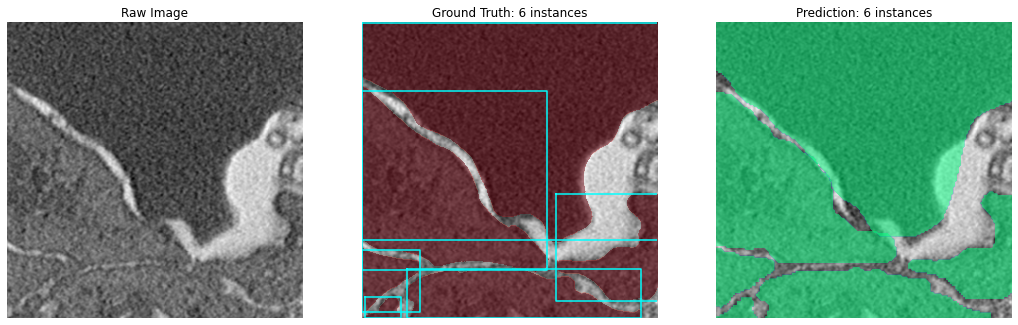

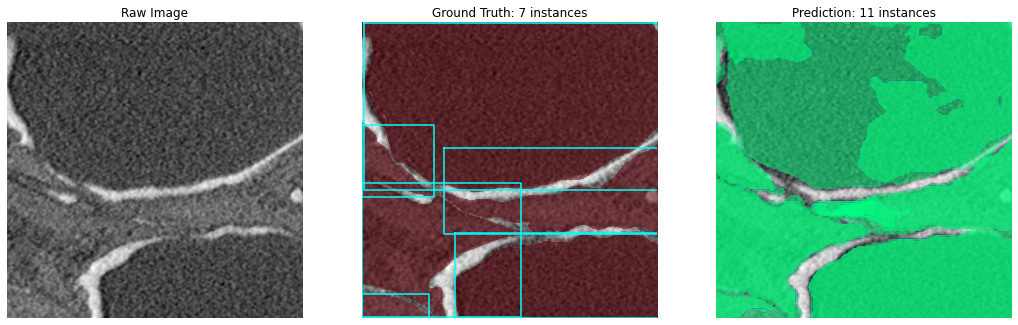

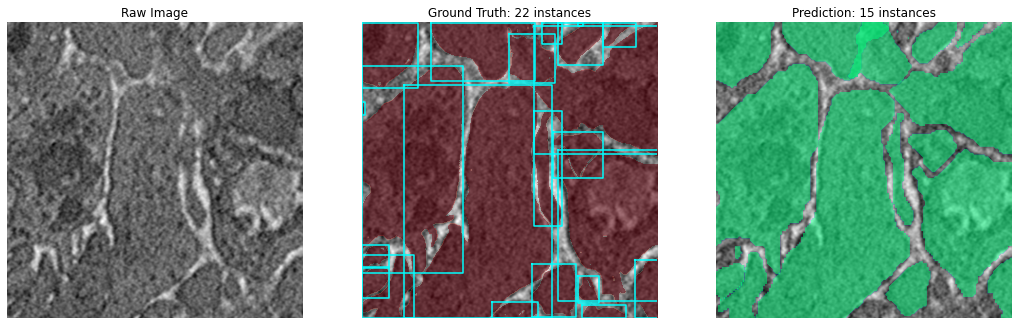

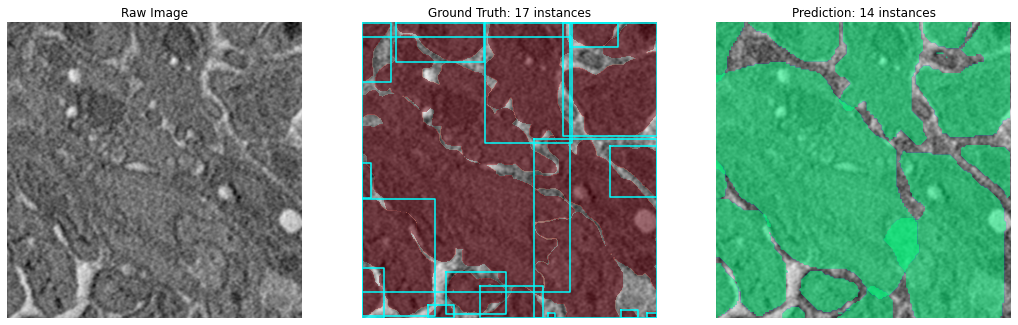

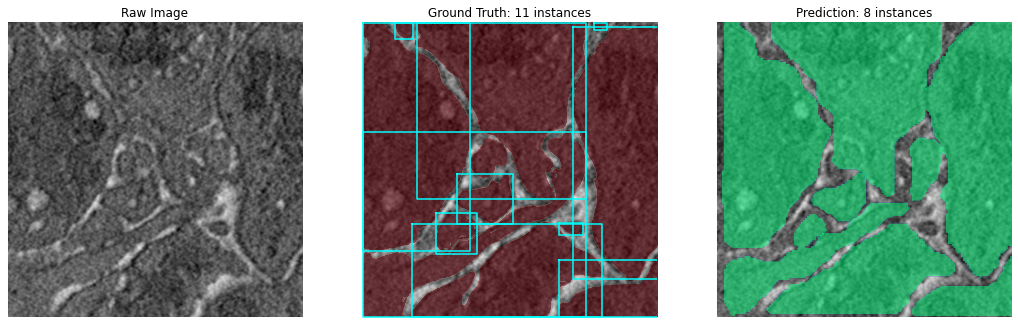

In [52]:
batch = 0
n_show = 5

# predict
model.eval()
for i, data in enumerate(train_loader):
# for i, data in enumerate(test_loader):
        
    images, masks, bboxes, _ = data
    masks, bboxes = [torch.Tensor(m) for m in masks], [torch.Tensor(b) for b in bboxes]
    original_img= [int(313/2),int(313/2)]
    
    post_out = model.post_processing(*model.forward(images.to(device),
                                                    device=device, 
                                                    eval=True, 
                                                    original_img=original_img),
                                     nms_score_threshold = nms_score_threshold)

    plt.figure(figsize = (18,6))

    plt.subplot(1, 3, 1)
    plt.title('Raw Image')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title(f'Ground Truth: {len(bboxes[batch])} instances')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    for box, msk in zip(bboxes[batch], masks[batch]):
        plt.plot(*draw_box(*box * 313).T, color = 'aqua')
        plt.imshow(msk, alpha = msk * 0.5, cmap = 'Reds')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f'Prediction: {len(post_out[batch])} instances')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    for msk in post_out[0]:
        m = (nn.functional.interpolate(msk[None, None].float(), size=images.shape[-2:], mode='bilinear') > 0.5)[0,0].int().cpu().numpy()
        plt.imshow(m, alpha = m * 0.5, cmap = 'winter')
    plt.axis('off')

    plt.savefig(f'{checkpoint_path}/solo-epoch-{num_epoch}-train-results-{i}.pdf', dpi = 100)
    plt.show()
    plt.close()
    if i == n_show-1:
        break





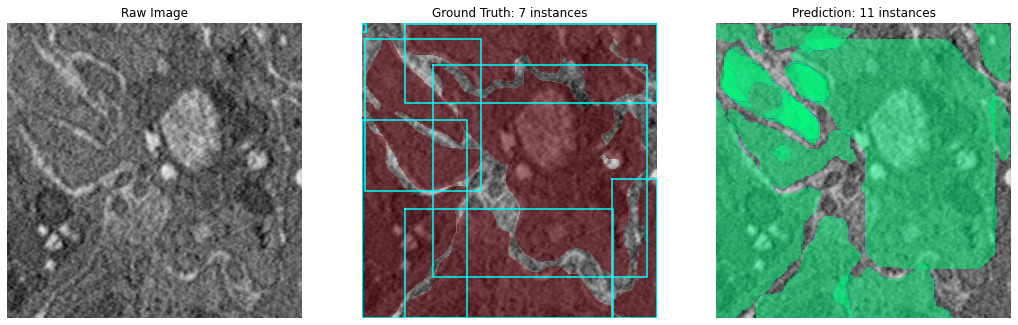

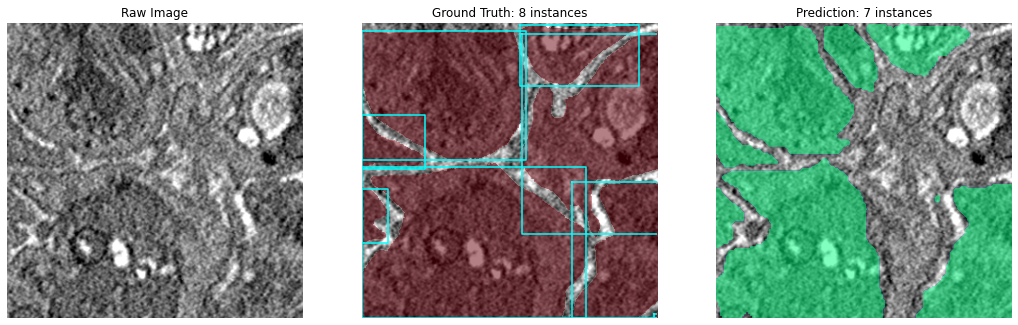

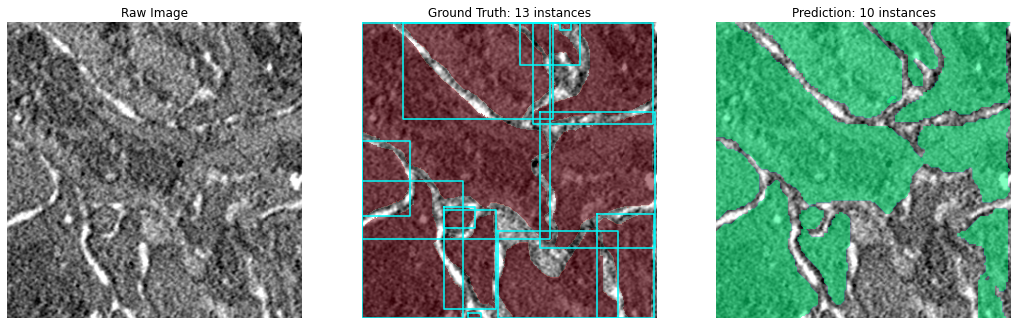

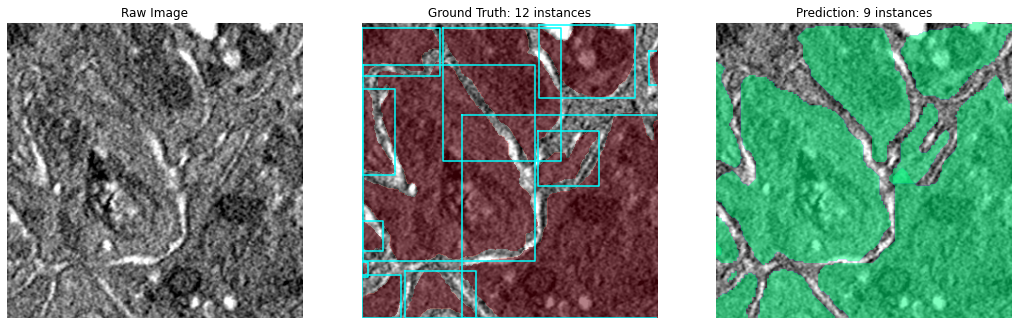

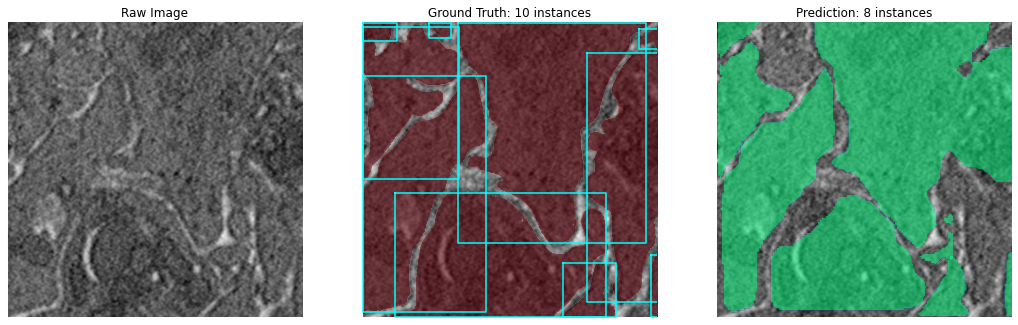

In [53]:


# predict
model.eval()
# for i, data in enumerate(train_loader):
for i, data in enumerate(test_loader):
        
    images, masks, bboxes, _ = data
    masks, bboxes = [torch.Tensor(m) for m in masks], [torch.Tensor(b) for b in bboxes]
    original_img= [int(313/2),int(313/2)]
    
    post_out = model.post_processing(*model.forward(images.to(device),
                                                    device=device, 
                                                    eval=True, 
                                                    original_img=original_img),
                                     nms_score_threshold = nms_score_threshold)

    plt.figure(figsize = (18,6))

    plt.subplot(1, 3, 1)
    plt.title('Raw Image')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title(f'Ground Truth: {len(bboxes[batch])} instances')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    for box, msk in zip(bboxes[batch], masks[batch]):
        plt.plot(*draw_box(*box * 313).T, color = 'aqua')
        plt.imshow(msk, alpha = msk * 0.5, cmap = 'Reds')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f'Prediction: {len(post_out[batch])} instances')
    plt.imshow(images[batch].squeeze(), cmap = 'gray')
    for msk in post_out[0]:
        m = (nn.functional.interpolate(msk[None, None].float(), size=images.shape[-2:], mode='bilinear') > 0.5)[0,0].int().cpu().numpy()
        plt.imshow(m, alpha = m * 0.5, cmap = 'winter')
    plt.axis('off')

    plt.savefig(f'{checkpoint_path}/solo-epoch-{num_epoch}-test-results-{i}.pdf', dpi = 100)
    plt.show()
    plt.close()
    if i == n_show-1:
        break



In [54]:
batch_size = 4
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Grayscale(),
                                                torchvision.transforms.Normalize([0.5], [0.5])])
train_loader = data_loader(train_files, DATA_DIR, batch_size = batch_size,transforms = transforms)
test_loader = data_loader(test_files, DATA_DIR, batch_size = batch_size,transforms = transforms)
%timeit out = model.forward(images.to(device),device=device,eval=True,original_img=original_img)
%timeit post_out = model.post_processing(*model.forward(images.to(device),device=device,eval=True,original_img=original_img),nms_score_threshold = nms_score_threshold)


68 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
309 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
